# Personalized Movie Recommendation System

**Author:** Shadin Chatila

**Date:** 2/20/2025

---

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Load the dataset (replace 'telecom_billing.csv' with actual dataset path)
df = pd.read_csv('/Users/shadinchatila/Downloads/telco_customer_data.csv')

2025-02-22 14:24:30.899381: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
df.head()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


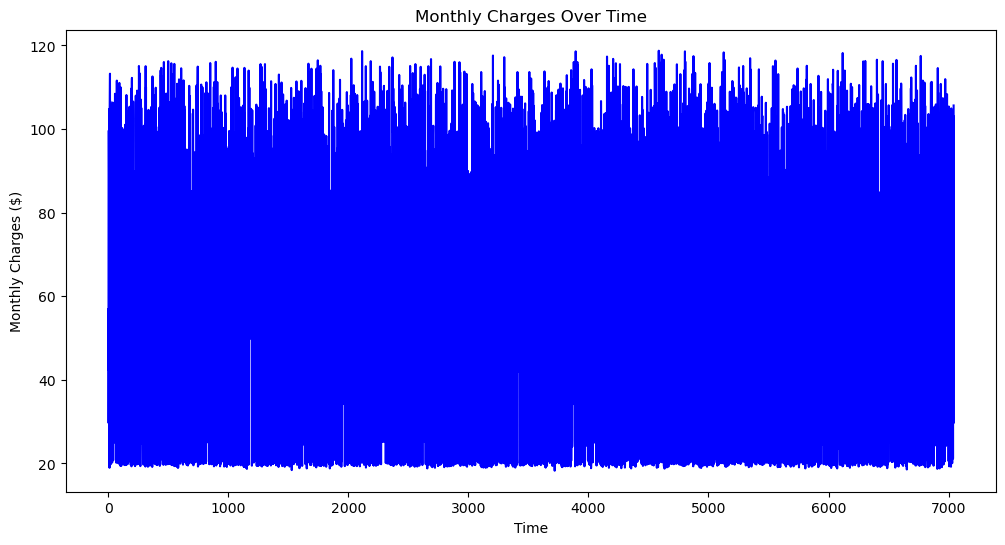

In [2]:
# Convert dates if available
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')

# Select relevant columns (assuming 'MonthlyCharges' is the target variable)
df = df[['MonthlyCharges']].dropna()

# Plot billing trends over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x=df.index, y='MonthlyCharges', color='blue')
plt.title('Monthly Charges Over Time')
plt.xlabel('Time')
plt.ylabel('Monthly Charges ($)')
plt.show()

In [3]:
# Check for stationarity (Dickey-Fuller Test)
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values: {result[4]}')
    return result[1] < 0.05

stationary = adf_test(df['MonthlyCharges'])

# Differencing if needed (for stationarity)
if not stationary:
    df['MonthlyCharges_diff'] = df['MonthlyCharges'] - df['MonthlyCharges'].shift(1)
    df.dropna(inplace=True)

# Train-test split for forecasting models
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# Train ARIMA model
arima_model = ARIMA(train['MonthlyCharges'], order=(1,1,1))
arima_model_fit = arima_model.fit()

# Predict using ARIMA
arima_pred = arima_model_fit.forecast(steps=len(test))
arima_rmse = np.sqrt(mean_squared_error(test['MonthlyCharges'], arima_pred))

# Train SARIMA model
sarima_model = SARIMAX(train['MonthlyCharges'], order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_model_fit = sarima_model.fit()

# Predict using SARIMA
sarima_pred = sarima_model_fit.forecast(steps=len(test))
sarima_rmse = np.sqrt(mean_squared_error(test['MonthlyCharges'], sarima_pred))

# Prepare data for ML models
X = np.arange(len(df)).reshape(-1, 1)  # Time index as feature
y = df['MonthlyCharges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))

# Train XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))

# Prepare LSTM data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

X_lstm, y_lstm = [], []
for i in range(10, len(scaled_data)):
    X_lstm.append(scaled_data[i-10:i, 0])
    y_lstm.append(scaled_data[i, 0])

X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

# Build LSTM model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(10,1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=16)

# Predict using LSTM
lstm_pred = lstm_model.predict(X_test_lstm)
lstm_rmse = np.sqrt(mean_squared_error(y_test_lstm, lstm_pred))

# Model performance comparison
model_performance = pd.DataFrame({
    'Model': ['ARIMA', 'SARIMA', 'Random Forest', 'XGBoost', 'LSTM'],
    'RMSE': [arima_rmse, sarima_rmse, rf_rmse, xgb_rmse, lstm_rmse]
})

ADF Statistic: -82.91468572919935
p-value: 0.0
Critical Values: {'1%': -3.431278952754844, '5%': -2.8619505228709277, '10%': -2.5669885173093383}


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.05932D+00    |proj g|=  7.77032D-02

At iterate    5    f=  4.97712D+00    |proj g|=  7.88433D-02

At iterate   10    f=  4.83182D+00    |proj g|=  9.32426D-02

At iterate   15    f=  4.82026D+00    |proj g|=  1.64041D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     19      1     0     0   1.255D-04   4.820D+00
  F =   4.8202598058799531     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.9991
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 1.0049
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 1.0013
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - loss: 0.9942
Epoch 5/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 1.0096
Epoch 6/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.9898
Epoch 7/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 1.0073
Epoch 8/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9933
Epoch 9/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.0052
Epoch 10/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9952
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


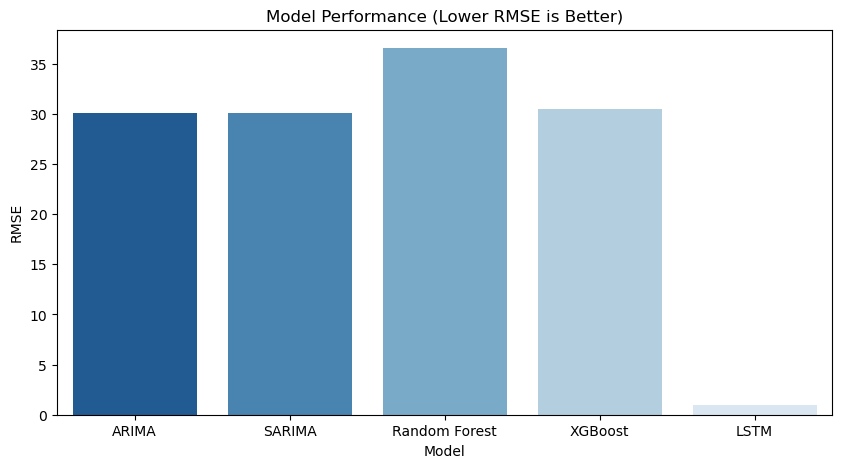

,Model,RMSE
0,ARIMA,30.050112
1,SARIMA,30.066497
2,Random Forest,36.576950
3,XGBoost,30.520817
4,LSTM,1.004249


In [5]:
#Plot model performance
plt.figure(figsize=(10, 5))
sns.barplot(x='Model', y='RMSE', data=model_performance, palette='Blues_r')
plt.title('Model Performance (Lower RMSE is Better)')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.show()

# Display model performance
from IPython.display import display
display(model_performance)
